In [1]:
import sys, os
import numpy as np
sys.path.append('../src/')
import torch
from MolGraphNetwork import MolGraphNetwork
from scf_guess_tools import Backend

BASIS_PATH = "pcseg-1"
GEOMETRY_Source = "/home/etschgi1/REPOS/Masterarbeit/datasets/QM9/xyz_c7h10o2_sorted"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MGNN = MolGraphNetwork(xyz_source=GEOMETRY_Source,
                       basis=BASIS_PATH,
                       backend=Backend.PY,
                       batch_size=16,
                       hidden_dim=128,
                       train_val_test_ratio=(0.8, 0.1, 0.1), 
                       message_passing_steps=3,
                       edge_threshold_val=5,
                       message_net_layers=3,
                       message_net_dropout=0.1,
                       target="fock",
                       verbose_level=2)
MGNN.load_data(max_samples=500,
               cache_meta = {"method":"dft", "basis":None, "functional": "b3lypg", "guess": "minao", "backend": "pyscf", "cache": "/home/etschgi1/REPOS/Masterarbeit/datasets/QM9/out/c7h10o2_b3lypg_pcseg1/pyscf"})

Setting verbose level to: 2
Loading 6095 files from /home/etschgi1/REPOS/Masterarbeit/datasets/QM9/xyz_c7h10o2_sorted...
Limiting to 500 samples out of 6095 total files.


Loading files: 100%|██████████| 500/500 [00:01<00:00, 392.14it/s]
Creating graphs: 500it [00:06, 75.06it/s]


Total samples: 500, Train: 400, Val: 50, Test: 50
Found 3 center keys (['C', 'H', 'O']) and 6 edge keys (['C_C', 'C_H', 'C_O', 'H_H', 'H_O', 'O_O']) in the training set. -> Totaling 9 unique encoder/decoder.
Normalization factors computed and applied.
Center stats: {'C': (0.15901810980978467, 0.3491067062811783), 'H': (0.376943039894104, 0.46880099786953644), 'O': (0.15833881823789506, 0.3483205718277696)}, Edge stats: {'C_C': (0.005134553565423481, 0.0889675083102608), 'C_H': (0.00834677313786791, 0.08766453453163513), 'C_O': (0.002090464134651648, 0.06415885490836759), 'H_H': (0.011921217465338906, 0.057036713807302165), 'H_O': (0.0027484030003733745, 0.04566583105516226), 'O_O': (-0.0003316036761995212, 0.016086349758749653)}
First train batch: 304 atoms, 5036 edges, 304 center blocks.
Found center block size 105 for atom type O.
Found center block size 105 for atom type C.
Found center block size 15 for atom type H.
Found edge block size 196 for edge type O_O.
Found edge block size

In [2]:
RETRAIN = False
model_name = "MGNN_pcseg1_simple"
if not RETRAIN and os.path.exists(f"/home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/{model_name}.pth"):
    MGNN.load_model(f"/home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/{model_name}.pth")
else:
    MGNN.train_model(num_epochs=10, lr=1e-3, weight_decay=1e-5, model_save_path=f"/home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/{model_name}.pth")
    MGNN.save_model(f"/home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/{model_name}.pth")

Loaded weights from /home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/MGNN_pcseg1_simple.pth (strict=True)


/home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/pcseg1_testing/../src/MolGraphNetwork.py:852: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.loa

In [3]:
test_graphs = MGNN.get_graphs("test")

Testing on random sample with id 19


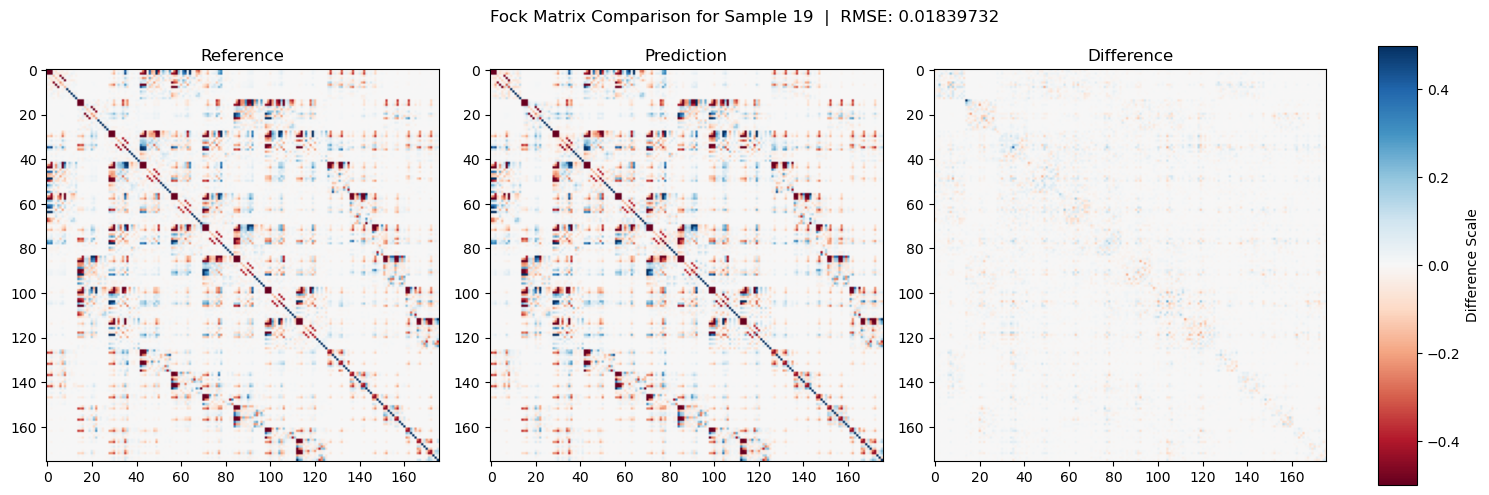

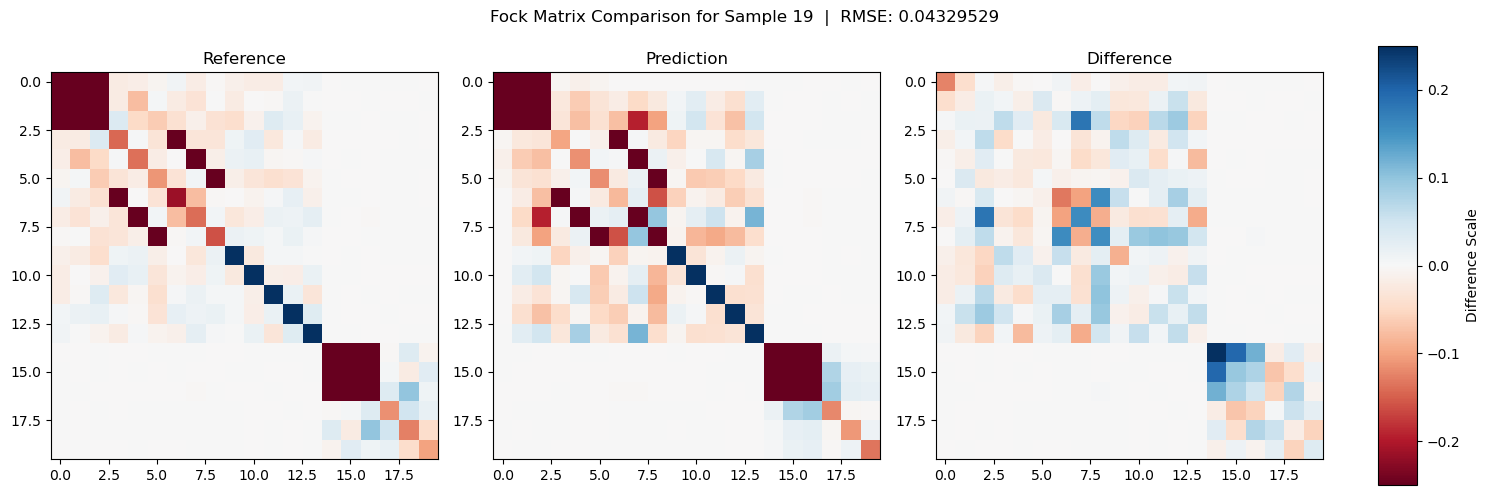

In [15]:
# aux code for testing
sys.path.append('../../')
from utils import plot_mat_comp

randsample_id = np.random.randint(0, len(test_graphs))
print(f"Testing on random sample with id {randsample_id}")
test_graph = test_graphs[randsample_id]
fock_pred = MGNN.predict([test_graph])[0]
fock_true = MGNN.get_ground_truth("test")[randsample_id]
plot_mat_comp(fock_pred, fock_true,
                     title=f"Fock Matrix Comparison for Sample {randsample_id}", vmax=0.5)
plot_mat_comp(fock_pred[:20, :20], fock_true[:20, :20],
                     title=f"Fock Matrix Comparison for Sample {randsample_id}", vmax=0.25)

Ovlp: [[1.         0.26261654 0.1722097  0.         0.         0.
  0.         0.         0.         0.        ]
 [0.26261654 1.         0.78225493 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.1722097  0.78225493 1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.46949825 0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.46949825 0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.46949825 0.        ]
 [0.         0.         0.         0.46949825 0.         0.
  1.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.46949825 0.
  0.         1.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.46949825
  0.         0.         1.         0.        ]
 [0.         0.        

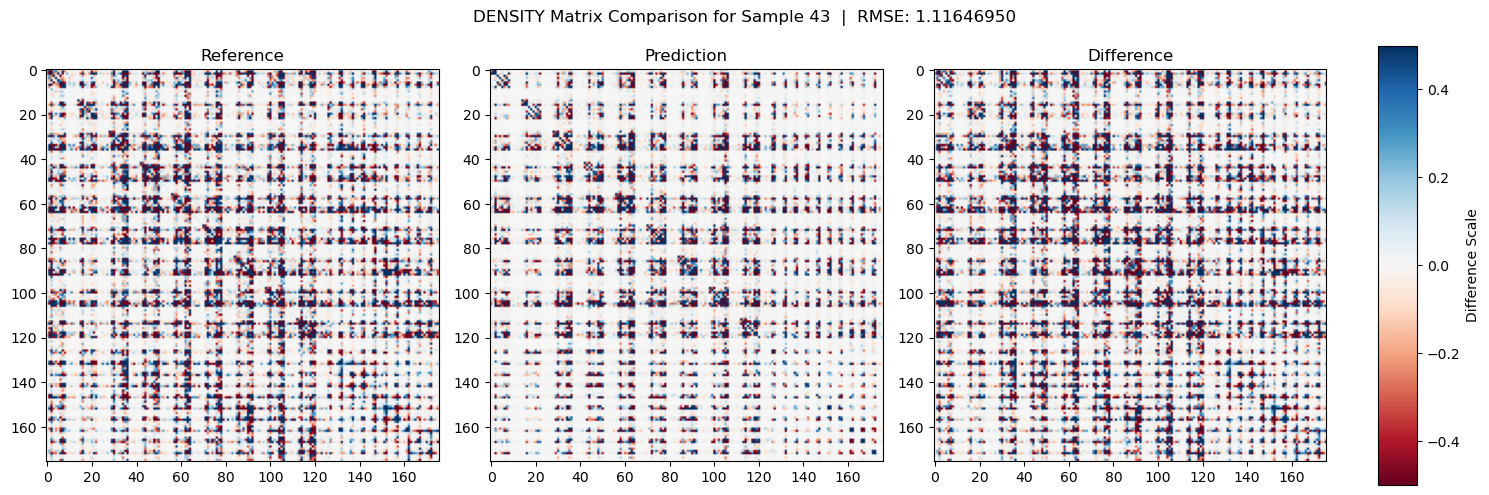

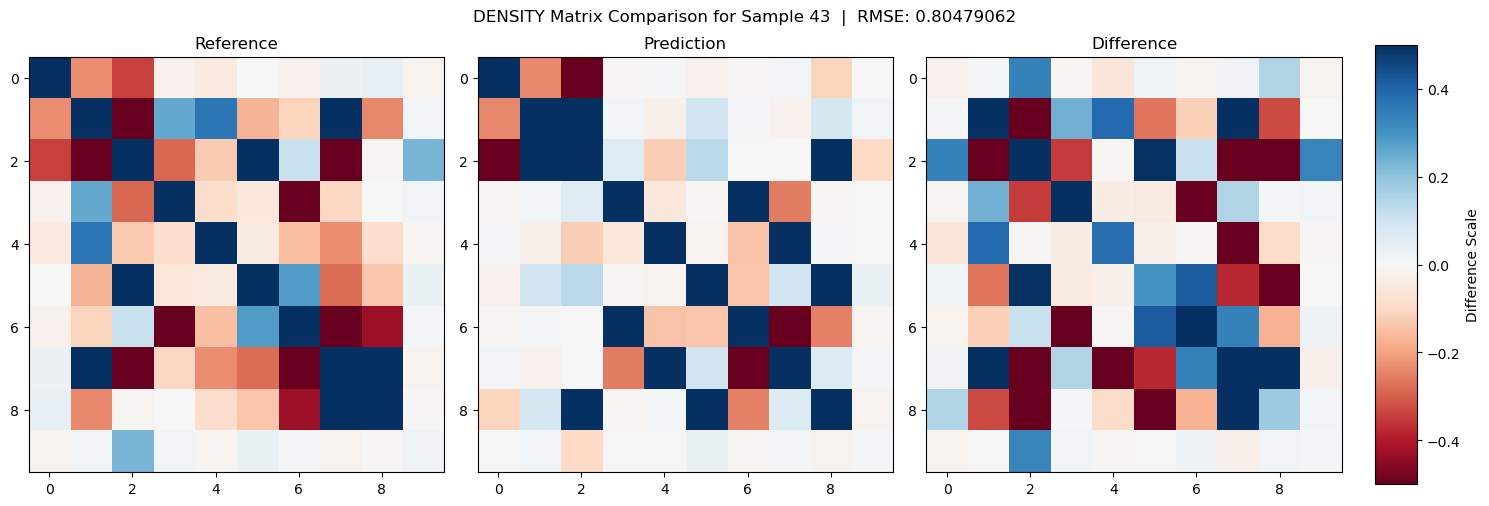

In [5]:
density_pred, density_truth = MGNN.predict([test_graph], include_target=True, transform_to_density=True)[0]
plot_mat_comp(density_pred, density_truth, 
                     title=f"DENSITY Matrix Comparison for Sample {randsample_id}", vmax=0.5)
plot_mat_comp(density_pred[:10,:10], density_truth[:10,:10], 
                     title=f"DENSITY Matrix Comparison for Sample {randsample_id}", vmax=0.5)

# Sanity check & test against ref sim!

In [6]:
from scf_guess_tools import load, calculate
from scipy.linalg import eigh
from pyscf import gto, scf

In [7]:
rand_file = MGNN.get_files("test")[randsample_id]
mol = load(rand_file, basis=BASIS_PATH, backend=Backend.PY)
wf = calculate(mol, basis=BASIS_PATH, functional="b3lypg", method="dft")
fock_recalc = wf.fock().numpy
density_recalc = wf.density().numpy

converged SCF energy = -423.012580534168


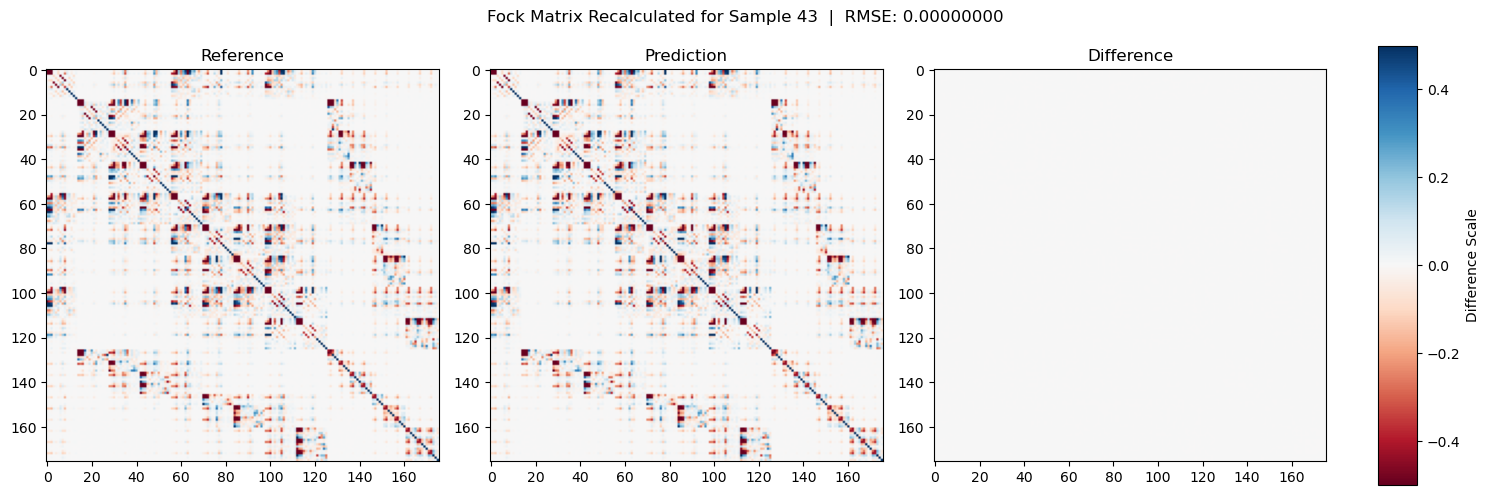

In [8]:
plot_mat_comp(fock_recalc, fock_true,
                     title=f"Fock Matrix Recalculated for Sample {randsample_id}", vmax=0.5)

ok there is no difference to the recalc vs. ground truth! Next check if we reconstruct the density correctly! 

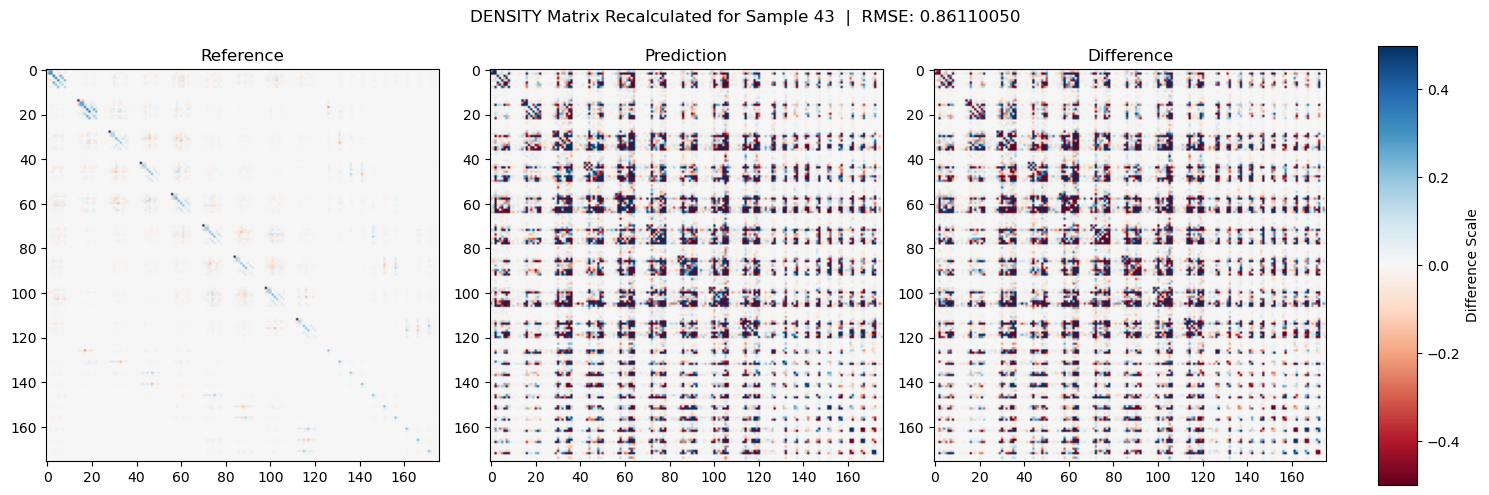

In [9]:
plot_mat_comp(density_recalc, density_truth, 
                     title=f"DENSITY Matrix Recalculated for Sample {randsample_id}", vmax=0.5)

No there is something odd going on - we fail the reconstruction! 

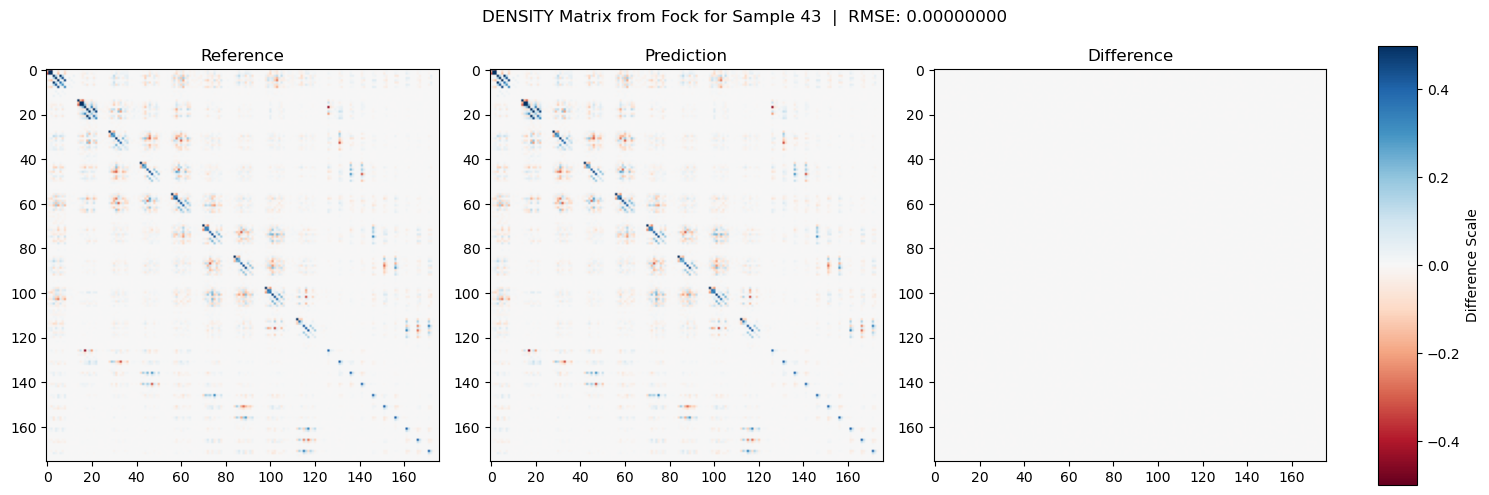

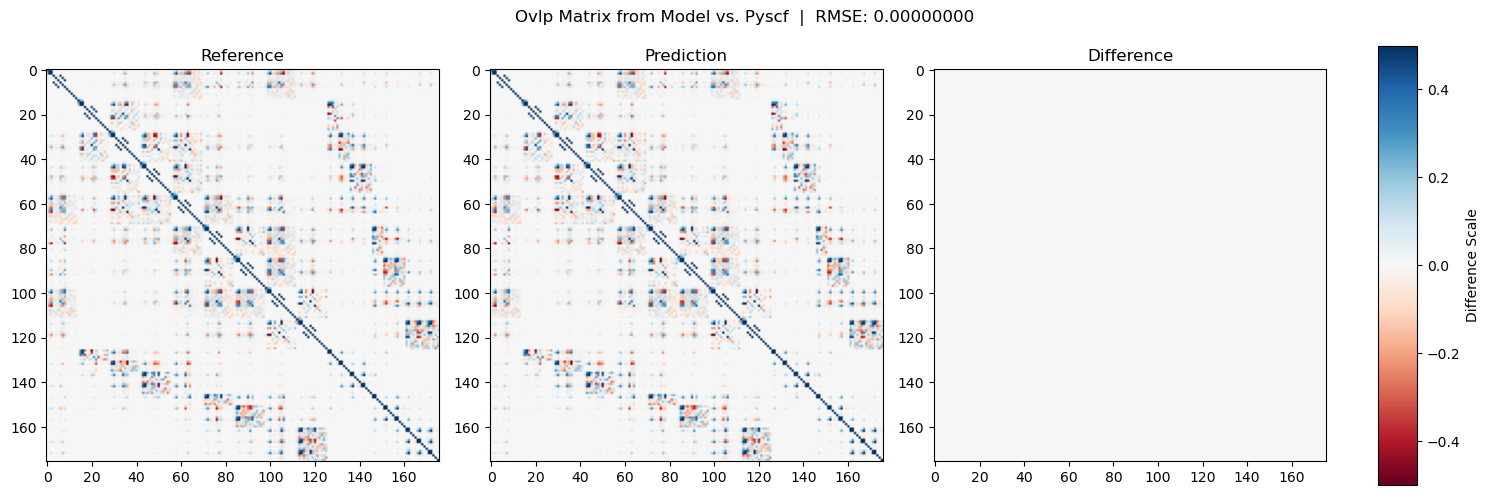

[[1.         0.26261655 0.17220969 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.26261655 1.         0.78225496 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.17220969 0.78225496 1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.46949825 0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.46949825 0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.46949825 0.        ]
 [0.         0.         0.         0.46949825 0.         0.
  1.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.46949825 0.
  0.         1.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.46949825
  0.         0.         1.         0.        ]
 [0.         0.         0.   

In [ ]:
# manually reconstruct density from fock: 
def check_positive_definite(S, tol=1e-10):
    eigvals = np.linalg.eigvalsh(S)
    is_pd = np.all(eigvals > tol)
    return is_pd

def density_from_fock(fock, overlap, nocc):
    assert check_positive_definite(overlap)
    _, C = eigh(fock, overlap)
    C_occ = C[:, :nocc]
    density = 2 * C_occ @ C_occ.T 
    return density

moln = mol.native
nocc = moln.nelectron // 2
density_from_fock_true = density_from_fock(fock_true, moln.intor("int1e_ovlp"), nocc)
density_from_fock_recalc = density_from_fock(fock_recalc, moln.intor("int1e_ovlp"), nocc)
plot_mat_comp(density_from_fock_recalc, density_from_fock_true, 
                     title=f"DENSITY Matrix from Fock for Sample {randsample_id}", vmax=0.5)
# ovlps from model
ovlp_for_trial = MGNN.get_source_mat("test")[randsample_id]
plot_mat_comp(ovlp_for_trial, moln.intor("int1e_ovlp"), title="Ovlp Matrix from Model vs. Pyscf", vmax=0.5) # ovlp is same! 